<a href="https://colab.research.google.com/github/gomlfx/ApiaryFund/blob/master/RS_vs_RL_searcher_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#tests potential HPO ability of random searcher and RL searcher

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def gaussian(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

x, y = np.linspace(0, 99, 100), np.linspace(0, 99, 100)
X, Y = np.meshgrid(x, y)

Z = np.zeros(X.shape)
ps = [(20, 70, 35, 40, 1),
      (80, 40, 20, 20, 0.7)]
for p in ps:
    Z += gaussian(X, Y, *p)

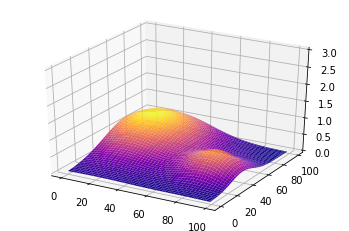

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_zlim(0,np.max(Z)+2)
plt.show()

In [ ]:
!pip install autogluon

     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 352 kB 40.6 MB/s 
     |████████████████████████████████| 273 kB 41.3 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 27.4 MB 1.3 MB/s 
     |████████████████████████████████| 4.2 MB 49.8 MB/s 
     |████████████████████████████████| 837 kB 54.6 MB/s 
     |████████████████████████████████| 210 kB 68.9 MB/s 
     |████████████████████████████████| 22.3 MB 1.3 MB/s 
     |████████████████████████████████| 132 kB 46.5 MB/s 
     |████████████████████████████████| 1.3 MB 49.3 MB/s 
     |████████████████████████████████| 119 kB 51.3 MB/s 
     |████████████████████████████████| 3.0 MB 38.1 MB/s 
     |████████████████████████████████| 296 kB 56.4 MB/s 
     |████████████████████████████████| 166.7 MB 16 kB/s 
     |████████████████████████████████| 2.0 MB 49.0 MB/s 
     |████████████████████████████████| 67.3 MB 13 kB/s 
     |█████████████

In [6]:
import autogluon.core as ag

@ag.args(
    x=ag.space.Categorical(*list(range(100))),
    y=ag.space.Categorical(*list(range(100))),
)
def rl_simulation(args, reporter):
    x, y = args.x, args.y
    reporter(accuracy=Z[y][x])

In [7]:
random_scheduler = ag.scheduler.FIFOScheduler(rl_simulation,
                                              resource={'num_cpus': 1, 'num_gpus': 0},
                                              num_trials=300,
                                              reward_attr='accuracy')
random_scheduler.run()
random_scheduler.join_jobs()
print('Best config: {}, best reward: {}'.format(random_scheduler.get_best_config(), random_scheduler.get_best_reward()))

  0%|          | 0/300 [00:00<?, ?it/s]

Best config: {'x▁choice': 22, 'y▁choice': 69}, best reward: 0.9961362873852471


In [10]:
!pip install --upgrade mxnet
import mxnet as mx
from distutils.version import LooseVersion

     |████████████████████████████████| 47.3 MB 76 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [11]:
rl_scheduler = ag.scheduler.RLScheduler(rl_simulation,
                                        resource={'num_cpus': 1, 'num_gpus': 0},
                                        num_trials=300,
                                        reward_attr='accuracy',
                                        controller_batch_size=4,
                                        controller_lr=5e-3,
                                        checkpoint='./rl_exp/checkerpoint.ag')
rl_scheduler.run()
rl_scheduler.join_jobs()
print('Best config: {}, best reward: {}'.format(rl_scheduler.get_best_config(), rl_scheduler.get_best_reward()))


Best config: {'x▁choice': 21, 'y▁choice': 74}, best reward: 0.9892484241569526


In [12]:
results_rl = [v[0]['accuracy'] for v in rl_scheduler.training_history.values()]
results_random = [v[0]['accuracy'] for v in random_scheduler.training_history.values()]

In [13]:
import statistics
results1 = [statistics.mean(results_random[i:i+10]) for i in range(0, len(results_random), 10)]
results2 = [statistics.mean(results_rl[i:i+10]) for i in range(0, len(results_rl), 10)]

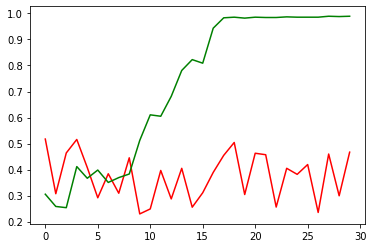

In [18]:
plt.plot(range(len(results1)), results1, 'r', range(len(results2)), results2, 'g')